In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns

/home/nvrancovich/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Paneo

In [2]:
segments = gpd.read_file('segmentacion_general_san_martin.geojson')
segments.rename(columns={'name':'area', 'description':'region'},inplace=True)
segments

,area,region,geometry
0,Lynch - Sur,Villa Lynch,"POLYGON Z ((-58.52226 -34.59736 0.00000, -58.5..."
1,Villa Maipu,Villa Maipu,"POLYGON Z ((-58.51502 -34.58139 0.00000, -58.5..."
2,San Martin,San Martin,"POLYGON Z ((-58.54791 -34.57601 0.00000, -58.5..."
3,Billinghurst - Norte,Billinghurst,"POLYGON Z ((-58.57804 -34.57871 0.00000, -58.5..."
4,Loma Hermosa,Loma Hermosa,"POLYGON Z ((-58.59056 -34.56881 0.00000, -58.5..."
5,San Andres - Norte,San Andres,"POLYGON Z ((-58.53783 -34.54422 0.00000, -58.5..."
6,Ballester - Las Heras Norte,Villa Ballester,"POLYGON Z ((-58.54942 -34.56177 0.00000, -58.5..."
7,Ballester - Gral. Guido,Villa Ballester,"POLYGON Z ((-58.58009 -34.54998 0.00000, -58.5..."
8,Ballester - VIlla De Sucre,Villa Ballester,"POLYGON Z ((-58.56118 -34.54686 0.00000, -58.5..."
9,Lynch - Villa Chacabuco,Villa Lynch,"POLYGON Z ((-58.53731 -34.58467 0.00000, -58.5..."


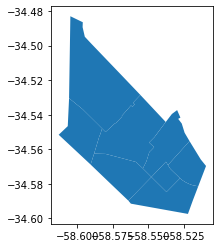

In [3]:
segments.dissolve(by='region').plot()

In [5]:
props = pd.read_csv('propiedades.csv')
props = gpd.GeoDataFrame(props, geometry=gpd.points_from_xy(props.longitude, props.latitude))
props = props.set_crs('EPSG:4326')

In [6]:
join = props.sjoin(segments, how='inner')

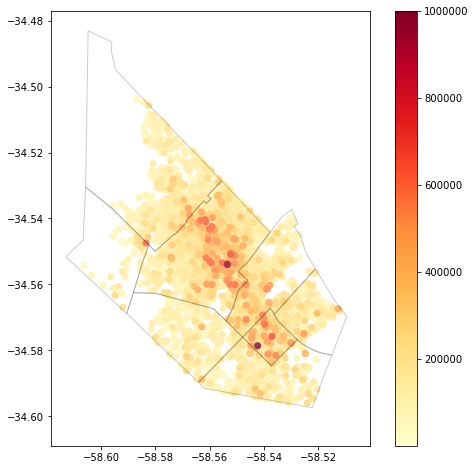

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
join.sort_values('price_USD').plot(ax=ax, column = 'price_USD', cmap = 'YlOrRd', legend=True,linewidth=1)
segments.dissolve(by='region').plot(ax=ax, alpha=0.2, edgecolor='Black', facecolor='White')
plt.show()

In [8]:
join['price/m2'] =  join.price_USD / join.covered_surface_m2

In [9]:
join.drop(axis=1, labels=['Unnamed: 0'], inplace=True)

# Limpieza

Primero mediante algunas graficas rapidas me doy cuenta que hay valores demasiado alejados del promedio, propiedades que tienen muy pocos metros cuadrados y con valores altisimos. Propiedades con valores altisimos demasiado elejados de la mediana de la zona. Asi que los limpio.

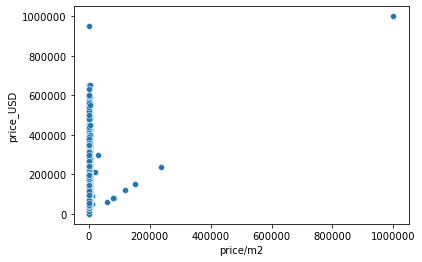

In [10]:
sns.scatterplot(x=join['price/m2'], y=join.price_USD)

In [11]:
join = join[join.covered_surface_m2 > 15]

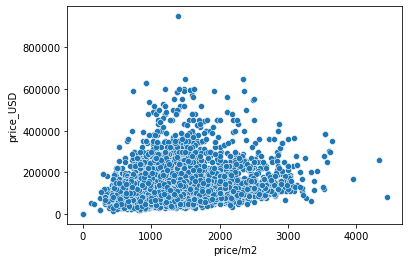

In [12]:
sns.scatterplot(x=join['price/m2'], y=join.price_USD)

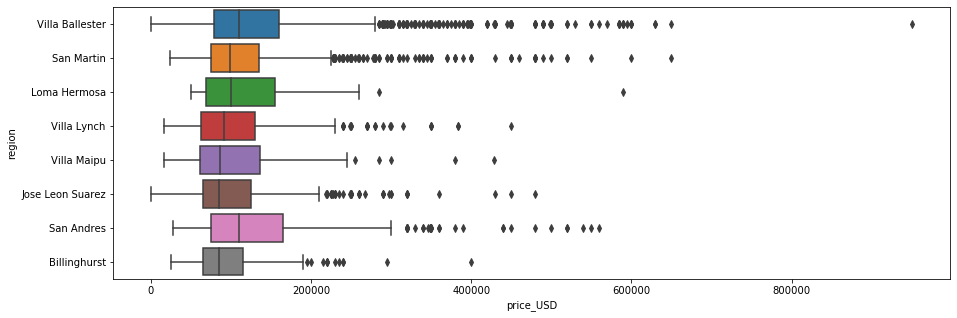

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(x=join.price_USD, y=join.region)

In [14]:
for i in list(join['area'].unique()):
    q = join[join['area'] == i].price_USD.quantile(0.90)
    join[join['area'] == i] = join[(join['area'] == i) & (join.price_USD < q)]

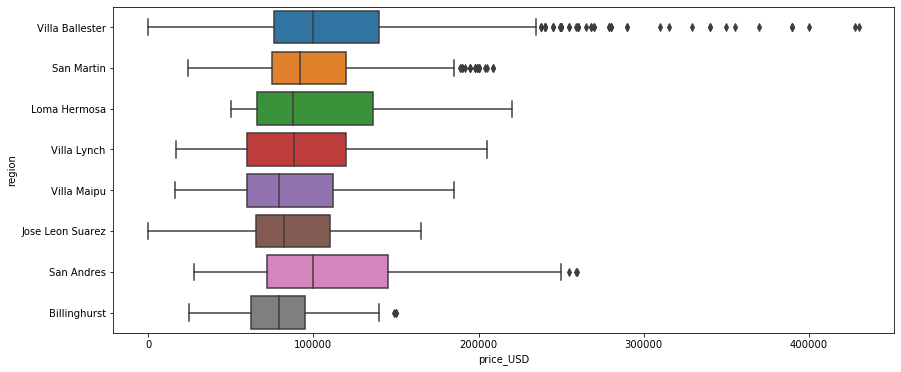

In [15]:
plt.figure(figsize=(14,6))
sns.boxplot(x=join.price_USD, y=join.region)

# Promedios

In [16]:
segments_avg = join.groupby('area').mean()[['covered_surface_m2', 'antiquity', 'price_USD', 'price/m2']].reset_index(level=0)
segments_avg[['area','price/m2']].to_csv('promedios_segmentos.csv')

In [17]:
m = folium.Map(location=[-34.55, -58.56], zoom_start=12.5)

folium.Choropleth(
    geo_data=segments,
    name='choropleth',
    data=segments_avg,
    columns=["area", "price_USD"],
    key_on= 'feature.properties.area',
    fill_color='RdYlGn_r',
    bins = 11,
    highlight = 'True',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Precio promedio en USD',
).add_to(m)

m

In [19]:
m = folium.Map(location=[-34.55, -58.56], zoom_start=12.5)

folium.Choropleth(
    geo_data=segments,
    name='choropleth',
    data=segments_avg,
    columns=["area", "antiquity"],
    key_on= 'feature.properties.area',
    fill_color='GnBu',
    bins = 8,
    highlight = 'True',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Antiguedad promedio en años',
).add_to(m)

m

In [20]:
m = folium.Map(location=[-34.55, -58.56], zoom_start=12.5)

folium.Choropleth(
    geo_data=segments,
    name='choropleth',
    data=segments_avg,
    columns=["area", "price/m2"],
    key_on= 'feature.properties.area',
    fill_color='RdYlGn_r',
    bins = 11,
    highlight = 'True',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Precio promedio por metro cuadrado en USD',
).add_to(m)

m

In [21]:
m = folium.Map(location=[-34.555, -58.56], zoom_start=12.5)

folium.Choropleth(
    geo_data=segments,
    name='superficie promedio m2',
    data=segments_avg,
    columns=["area", "covered_surface_m2"],
    key_on= 'feature.properties.area',
    fill_color='Greens',
    bins = 9,
    highlight = 'True',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Superficie promedio en metros cuadrados',
).add_to(m)

m

In [22]:
join.groupby('area').price_USD.describe()

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
Ballester - Alvear Norte,351.0,126030.111111,48225.393253,50000.0,90000.0,115000.0,150000.0,268000.0
Ballester - Alvear Sur,269.0,119445.349442,48604.839971,45000.0,82000.0,110000.0,150000.0,279000.0
Ballester - Gral. Guido,603.0,105432.668325,40841.568059,35000.0,75000.0,95000.0,130000.0,210000.0
Ballester - Las Heras Norte,114.0,160185.877193,102833.248444,90.0,79250.0,127500.0,227500.0,430000.0
Ballester - Las Heras Sur,167.0,119807.185629,55753.941531,40000.0,75000.0,108000.0,155000.0,265000.0
Ballester - Norte,579.0,108826.419689,45695.350010,22000.0,73500.0,97000.0,136500.0,249000.0
Ballester - VIlla De Sucre,178.0,107195.505618,40399.973178,30000.0,70000.0,102500.0,135000.0,198000.0
Ballester - Villa Zapiola,117.0,82374.358974,27458.184992,30000.0,65000.0,80000.0,97000.0,148000.0
Billinghurst - Norte,68.0,75136.750000,23046.035164,25000.0,60000.0,72999.5,90000.0,130000.0


In [23]:
join.groupby('region').price_USD.describe().reset_index()

,region,count,mean,std,min,25%,50%,75%,max
0,Billinghurst,261.0,81566.582375,27873.413244,25000.0,62500.0,79000.0,95000.0,150000.0
1,Jose Leon Suarez,745.0,87485.123490,32185.228984,95.0,65000.0,82000.0,110000.0,165000.0
2,Loma Hermosa,40.0,105160.000000,48630.536993,50000.0,65750.0,87500.0,136250.0,220000.0
3,San Andres,699.0,111527.440629,49465.658644,27500.0,72000.0,100000.0,145000.0,259500.0
4,San Martin,1132.0,99545.990283,34422.654600,24000.0,75000.0,91900.0,120000.0,208737.0
5,Villa Ballester,2378.0,113516.128680,51226.140221,90.0,76062.5,100000.0,140000.0,430000.0
6,Villa Lynch,355.0,91380.222535,36869.797946,17000.0,60000.0,88000.0,120000.0,205000.0
7,Villa Maipu,249.0,89568.775100,40566.872203,16000.0,59900.0,79000.0,111900.0,185000.0


In [24]:
join.groupby('area')['price/m2'].describe()

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
Ballester - Alvear Norte,351.0,2071.015427,466.669077,750.000000,1769.449715,2125.000000,2350.212766,3571.428571
Ballester - Alvear Sur,269.0,1878.807461,521.206751,566.666667,1571.428571,1858.974359,2208.955224,3531.645570
Ballester - Gral. Guido,603.0,1530.018090,506.106261,465.217391,1156.395349,1533.333333,1875.000000,2924.528302
Ballester - Las Heras Norte,114.0,1740.750481,519.083549,1.764706,1400.000000,1769.139194,2061.383929,3260.869565
Ballester - Las Heras Sur,167.0,1167.567409,371.562230,129.268293,909.090909,1161.290323,1381.385281,2271.428571
Ballester - Norte,579.0,1536.882499,501.675131,406.250000,1142.857143,1533.333333,1881.652661,3416.666667
Ballester - VIlla De Sucre,178.0,1316.568574,431.887446,416.666667,1019.142857,1307.894737,1567.460317,2603.773585
Ballester - Villa Zapiola,117.0,939.116813,372.160287,350.000000,703.125000,877.777778,1133.333333,3214.285714
Billinghurst - Norte,68.0,870.975701,357.988708,326.530612,600.000000,853.571429,1012.096774,2316.666667


In [25]:
join.groupby('area')['covered_surface_m2'].describe()

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
Ballester - Alvear Norte,351.0,64.301994,34.065818,22.0,45.0,55.0,75.00,300.0
Ballester - Alvear Sur,269.0,70.680297,45.913388,22.0,45.0,53.0,78.00,300.0
Ballester - Gral. Guido,603.0,79.771144,51.338988,20.0,45.0,60.0,100.00,415.0
Ballester - Las Heras Norte,114.0,102.368421,80.179363,23.0,47.5,67.0,128.25,370.0
Ballester - Las Heras Sur,167.0,115.940120,76.487396,31.0,61.0,100.0,147.50,500.0
Ballester - Norte,579.0,78.915371,44.681357,18.0,44.0,65.0,100.00,291.0
Ballester - VIlla De Sucre,178.0,94.370787,54.982253,16.0,49.0,84.0,120.00,298.0
Ballester - Villa Zapiola,117.0,99.153846,46.619815,28.0,64.0,90.0,121.00,210.0
Billinghurst - Norte,68.0,101.823529,55.223546,26.0,61.5,87.5,127.00,271.0


In [26]:
join.price_USD.mean()

103430.51629970985

In [27]:
join.price_USD.std()

45181.53687306221

In [28]:
join.covered_surface_m2.mean()

81.51391022358764

In [29]:
join.antiquity.mean()

25.669660902762182

In [30]:
sellers = join.groupby('seller').count()
sellers['percentage'] = sellers.type / sellers.type.sum()
sellers.rename(columns={'type':'count'}, inplace=True)
sellers = sellers[['count','percentage']].reset_index()
sellers

,seller,count,percentage
0,A. Romero,13,0.002219
1,ABDUCH PROPIEDADES,102,0.017409
2,AJB BIENES RAICES,7,0.001195
3,ALAN FANATICO GESTION INMOBILIARIA,65,0.011094
4,ALAN FANATICO GESTION INMOBILIARIA SUC.1,69,0.011777
...,...,...,...
420,Veronica Espinosa Negocios Inmobiliarios,1,0.000171
421,WAIMAN PROPIEDADES,1,0.000171
422,ZAMBORAIN CABRERA PROPIEDADES,1,0.000171
423,ZAMPONE PROPIEDADES-DANIEL A.ZAMPONE-M5792 CMS...,7,0.001195


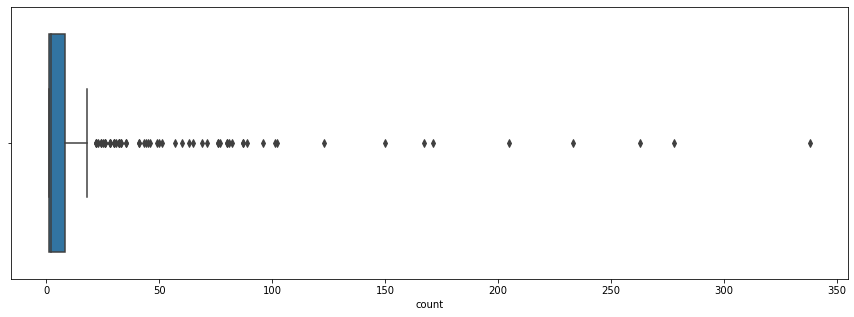

In [31]:
plt.figure(figsize=(15,5))
sns.boxplot(x=sellers['count'])